In [1]:
from blocked_gibbs import *
import warnings
warnings.filterwarnings(action='ignore')

/Users/kakao/opt/anaconda3/lib/python3.9/site-packages/arviz/__init__.py:317: UserWarning: Trying to register the cmap 'cet_gray' which already exists.
  register_cmap("cet_" + name, cmap=cmap)
/Users/kakao/opt/anaconda3/lib/python3.9/site-packages/arviz/__init__.py:317: UserWarning: Trying to register the cmap 'cet_gray_r' which already exists.
  register_cmap("cet_" + name, cmap=cmap)


## Generate example data

(398, 2)


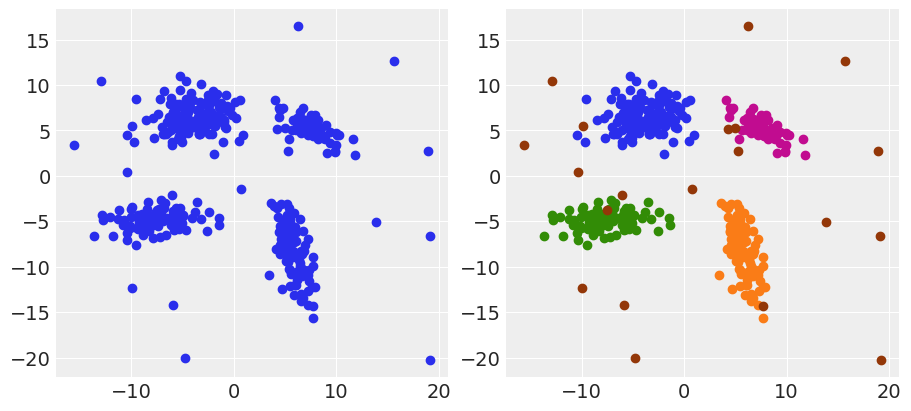

In [2]:
## 데이터 생성

from scipy.stats import multivariate_normal


np.random.seed(20220122)

# Prepare dataset
mu1 = [-4, 6.4]
cov1 = np.array([[5, 2.1],[-1.3, 2]])

mu2 = [5.6, -7.9]
cov2 = np.array([[0.9, -1.3],[-1.5, 7]])

mu3 = [-7.3, -4.98]
cov3 = np.array([[6, 0.1],[0.32, 1]])

mu4 = [7.1, 5.5]
cov4 = np.array([[3.5, -2.2],[-1.5, 2]])

g1 = multivariate_normal(mean=mu1, cov=cov1)
g2 = multivariate_normal(mean=mu2, cov=cov2)
g3 = multivariate_normal(mean=mu3, cov=cov3)
g4 = multivariate_normal(mean=mu4, cov=cov4)

samples = list()
samples.append(g1.rvs(130))
samples.append(g2.rvs(108))
samples.append(g3.rvs(87))
samples.append(g4.rvs(53))

min_temp = np.min(samples[0]) - 10
max_temp = np.max(samples[0]) + 10
outlier = np.random.uniform(min_temp, max_temp, size=(20,2))
samples.append(outlier)


data = np.vstack(samples)
data = data
np.random.shuffle(data) # randomly suffle instances
print(data.shape)

# Viz
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
axes[0].scatter(data[:, 0], data[:, 1])
for sample in samples:
    axes[1].scatter(sample[:, 0], sample[:, 1])

## Train DPGMM

Running burnin period... #samples: 200


  0%|          | 0/200 [00:00<?, ?it/s]

Burnin finished. Sampling started...



  0%|          | 0/1000 [00:00<?, ?it/s]

########################################################################################
########################################################################################
<1 / 1000>
220.03160 sec

Posterior cluster weights :
[0.325 0.284 0.22  0.123 0.02  0.014 0.004 0.004 0.002 0.001 0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]

Number of numerical errors: 0



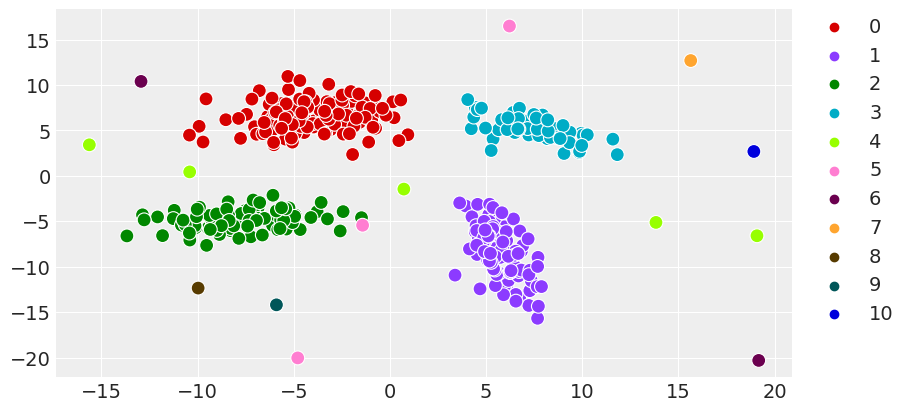


########################################################################################
########################################################################################
<1000 / 1000>
1053.19973 sec

Posterior cluster weights :
[0.322 0.278 0.19  0.146 0.022 0.012 0.007 0.003 0.003 0.003 0.002 0.002
 0.002 0.002 0.001 0.001 0.001 0.001 0.    0.   ]

Number of numerical errors: 0



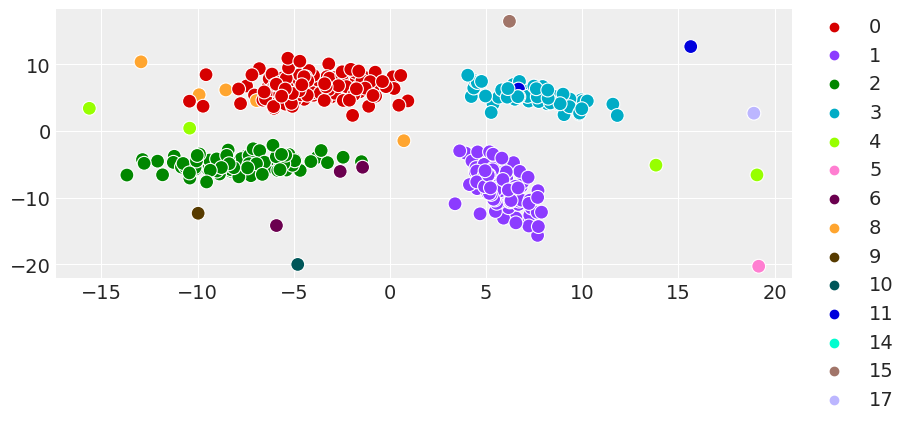


########################################################################################
########################################################################################
Sampling finished w/ total run time: 1274.79773 sec
Traces of ['C', 'PI', 'MU', 'S', 'NU', 'LAMBDA'] saved at current directory.
posterior probability greater than 0.05: [0 1 2 3]


In [3]:
# DPGMM 인스턴스 정의
dpgmm = DPGMM_SBP(data, alpha=1)

# DPGMM 훈련
num_iter = 1000
dpgmm.fit_transform(num_iter=num_iter, burnin=0.2, verbose=num_iter)

## Posterior Analysis

In [4]:
# posterior trace 불러오기
trace = az.from_netcdf("trace").posterior

temp = np.array(trace.PI).mean(axis=1).reshape(-1)
normal_idx = np.where(temp > 0.05)[0]
anomaly_idx = np.unique(trace.C)[~np.isin(np.unique(trace.C), normal_idx)]
print("posterior probability greater than 0.05: {}".format(normal_idx))
print(normal_idx)
print(anomaly_idx)

posterior probability greater than 0.05: [0 1 2 3]
[0 1 2 3]
[ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## cluster weights

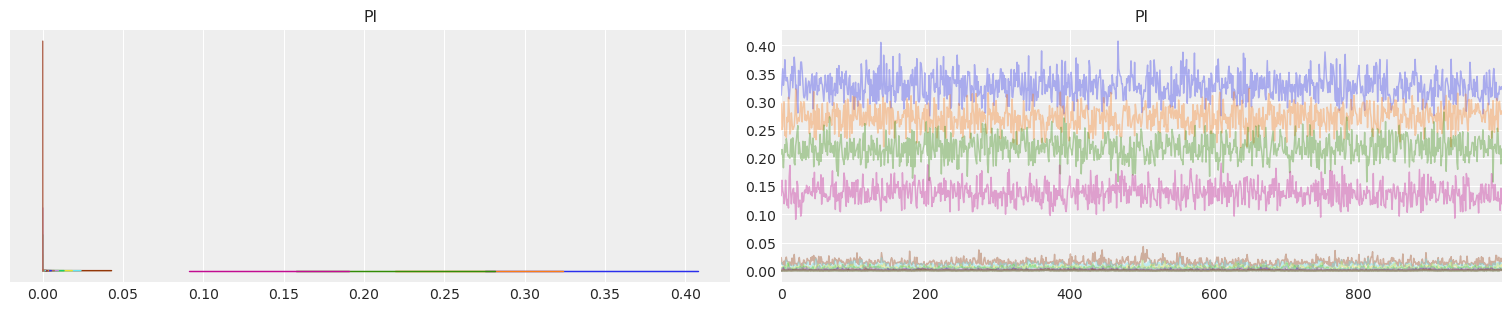

In [5]:
# cluster weights
az.plot_trace(trace.PI, figsize=(15,3))
plt.show()

## Model Parameter

In [6]:
def get_params(trace, idx):
    nu_temp = np.array(trace.NU[0][:, idx])
    S_temp = np.array(trace.S[0][:, idx, :, :])
    MU_temp = np.array(trace.MU[0][:, idx, :])
    LAMBDA_temp = np.array(trace.LAMBDA[0][:, idx])

    # covariance matrix
    cov_samples = invwishart.rvs(df=nu_temp.mean(), scale=S_temp.mean(axis=0), size=1000)
    cov_temp = cov_samples.mean(axis=0)

    # mean vector
    mean_samples = multivariate_normal.rvs(mean=MU_temp.mean(axis=0), cov=cov_temp/LAMBDA_temp.mean(), size=1000)
    mean_temp = mean_samples.mean(axis=0)

    return mean_temp, cov_temp

def draw_ellipse(position, covariance, cm, label, ax=None, **kwargs):
# def draw_ellipse(position, covariance, ax=None, **kwargs):
    from matplotlib.patches import Ellipse
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    plt.plot()
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, angle, facecolor=cm(label), alpha=0.8*1/nsig))

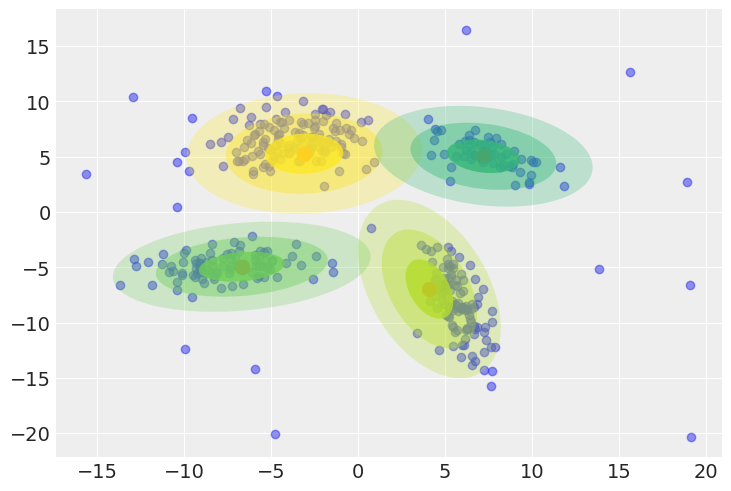

In [7]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
for idx in normal_idx:
    mean_vec, cov_mat = get_params(trace, idx)
    plt.scatter(mean_vec[0], mean_vec[1], c='red', s=100)
    cm = plt.cm.get_cmap('viridis_r', 10)
    draw_ellipse(mean_vec, cov_mat, cm, idx)

## object-specific

In [8]:
import bokeh

cluster_assignments = np.zeros(len(data))
assign_dict = dict()

for idx in range(len(data)):
    assign_prob = pd.Series(trace.C[0][:, idx]).value_counts() / pd.Series(trace.C[0][:, idx]).value_counts().sum()
    cluster_assignments[idx] = assign_prob.index[0]
    assign_dict[idx] = dict(assign_prob)

In [9]:
from bokeh.models import ColumnDataSource
from bokeh.layouts import widgetbox
from bokeh.plotting import figure, show, output_notebook
from bokeh.palettes import Category20
from bokeh.models import HoverTool

# dataframe for viz
df_viz = pd.DataFrame(data, columns=["x", "y"])
df_viz["cluster"] = cluster_assignments
df_viz["prob"] = assign_dict.values()
df_viz["prob"] = df_viz["prob"].astype(str)

# Create hover tooltip
hover_tool = HoverTool(tooltips = [
    ("클러스터 배정 확률", "@prob")
])

# Create the mapper
factors = np.unique(cluster_assignments)
palette = Category20[len(factors)]

# Create plot instance & add scatter glyph
plot = figure(title="클러스터별 분포 시각화", width=800, height=500)

for factor, color in zip(factors, palette):
    data_temp = df_viz[df_viz.cluster == factor]
    # Define data object
    source = ColumnDataSource(data_temp)
    plot.circle(x="x", y="y", source=source, color=color, size=8, muted_color=color, muted_alpha=0, legend_label=str(factor))

plot.add_tools(hover_tool)
plot.legend.click_policy = "mute"

# Show Plot
output_notebook()
show(plot)

Loading BokehJS ...